# <center> Modélisation

Dans cette section, nous cherchons à prédire la gravité de l'accident grâce aux variables explicatives telles que le type de la collision, le type de la route, la luminosité, etc. \
Pour cela, notre variable cible s'appelle "gravite", elle vaut 1 si lors de l'accident, il y a eu au moins un blessé hospitalisé et/ou une personne tuée et elle vaut 0 sinon (les usagers sont soit indemnes, soit des blessés légers).

In [11]:
%run "./Ouverture_donnees.ipynb"

Les importations nécessaires à la modélisation : 

In [6]:
import scipy.stats as ss
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import svm
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn import tree

In [4]:
#df_accidents.columns

## Préparation des données

Pour une meilleure modélisation, il est essentiel d'avoir un nombre de modalités raisonnable. Ainsi, nous regroupons les modalités ensemble si elles correspondent à un pourcentage d'accidents graves proche.

In [36]:
# Mettre des modalités ensemble :
df_accidents["collision"] = df_accidents["collision"].replace(["2 - frontale", "2-arriere", "3 vehicules", "2-cote"], "2 ou 3 véhicules")

df_accidents["catr"] = df_accidents["catr"].replace(["Route départementale", "Route nationale", "Autre"], "Route départementale ou nationale + Autre")
df_accidents["catr"] = df_accidents["catr"].replace(["Autoroute", "Voie Communale"], "Autoroute + Voie Communale")

df_accidents["lum"] = df_accidents["lum"].replace(["Crépuscule ou aube"], "Plein jour")

df_accidents["obstacle_fixe"] = df_accidents["obstacle"].replace(["1 obstacle mobile", "Pas dobstacle"], 0)
df_accidents["obstacle_fixe"] = df_accidents["obstacle_fixe"].replace(["1 obstacle mobile et 1 obstacle fixe", "1 obstacle fixe"], 1)


## Sélection de variables
Dans un premier temps, on étudie le pouvoir prédictif des variables explicatives. \
Le V de Cramer mesure l'association entre la variable explicative et la variable cible "gravité". On a réalisé un test d'indépendance du Chi-2. Si la p-valeur est inférieur à 0.05, alors l'hypothèse nulle d'indépendance est rejetée et il existe une dépendance entre la variable explicative et la variable cible. \
On retrouve ci-dessous les différentes valeurs de V de Cramer et de p-valeurs.

In [27]:
colonne = ["agglo", "lum", "int", "collision", "atm", "catr", "circ", "surf", "prof", "plan", "infra", "situ", "obstacle_fixe", "pieton"]

def cramers(df):
    L_cramer = []
    L_pvalue = []
    L_var = []
    for elem in colonne :
        crosstab = pd.crosstab(df[elem], df.gravite, margins = True, normalize = 'index')*100
        chi2 = ss.chi2_contingency(crosstab)[0]
        p_value = round(ss.chi2_contingency(crosstab)[1], 3)
        n = sum(crosstab.sum())
        VCramer = round(np.sqrt(chi2 / (n*(min(crosstab.shape)-1))), 3)
        #print("Pour la variable " + elem + ", le V de Cramer est : " + VCramer.astype(str))
        #print("La p-valeur du test du Chi-2 est : " + p_value.astype(str))
        L_cramer.append(VCramer)
        L_pvalue.append(p_value)
        L_var.append(elem)
    tableau = np.array([L_cramer, L_pvalue])
    pd_tableau = pd.DataFrame(tableau.T, index = L_var, columns = ['V de Cramer', 'p_value'])
    return pd_tableau.sort_values("p_value")

cramers(df_accidents)

,V de Cramer,p_value
situ,0.288,0.000
obstacle_fixe,0.206,0.000
agglo,0.209,0.001
catr,0.221,0.001
circ,0.200,0.001
lum,0.191,0.002
plan,0.151,0.032
collision,0.139,0.051
prof,0.095,0.261
atm,0.080,0.465


Ainsi, les variables utilisées seront Catr (le type de route), Situ (lieu de l'accident), Agglo (si l'accident a lieu en agglomération), Circ (le sens de circulation), Lum (la lminosité), plan (si la route est rectiligne ou courbée) et collision.

Créer les indicatrices nécessaires

In [32]:
# Variable cible :
df_accidents["y"] = (df_accidents["gravite"]==2).astype(int)


# Variables explicatives :
df_accidents["Sans collision"] = pd.get_dummies(df_accidents["collision"])["Sans collision"]
df_accidents["Autre collision"] = pd.get_dummies(df_accidents["collision"])["autre"]

df_accidents["Route dep ou nationale"] = pd.get_dummies(df_accidents["catr"])["Route départementale ou nationale + Autre"]

df_accidents["Sur accotement"] = pd.get_dummies(df_accidents["situ"])["Sur accotement"]
df_accidents["Autre lieu de l'accident"] = pd.get_dummies(df_accidents["situ"])["Autre"]

df_accidents["Hors agglomeration"] = pd.get_dummies(df_accidents["agglo"])["Hors agglomeration"]

df_accidents["A chaussées séparées"] = pd.get_dummies(df_accidents["circ"])["A chaussées séparées"]
df_accidents["Bidirectionnelle"] = pd.get_dummies(df_accidents["circ"])["Bidirectionnelle"]

df_accidents["Nuit sans éclairage"] = pd.get_dummies(df_accidents["lum"])["Nuit sans éclairage public"]
df_accidents["Plein jour"] = pd.get_dummies(df_accidents["lum"])["Plein jour"]

df_accidents["Courbe"] = pd.get_dummies(df_accidents["plan"])["Courbe"]

In [37]:
df_accidents["obstacle_fixe"].value_counts()

0      51035
1      13620
NaN       61
Name: obstacle_fixe, dtype: int64

In [128]:
#data = pd.get_dummies(df_accidents[col],drop_first=True)

Créer les échantillons de test et d'apprentissage

In [43]:
# Les variables explicatives sous forme d'indicatrices
col = ["Route dep ou nationale", "Sur accotement", "Autre lieu de l'accident", "Hors agglomeration",
       "A chaussées séparées", "Bidirectionnelle", "Nuit sans éclairage", "Plein jour",
       "Sans collision", "Autre collision", "Courbe"]

# Créer de la base de donner avec uniquement les variables explicatives
df_temp = df_accidents[col]

# Création des échantillons de test et d'apprentissage
xTrain, xTest, yTrain, yTest = train_test_split(df_temp, df_accidents["y"].values.ravel(), test_size = 0.2, random_state = 0)

## Modélisation et performance du modèle

Nous allons étudier différents types de modèles :
* Classification
* Régression linéaire
* Arbre de décision

Pour cela, nous codons des fonctions pour tracer les courbes ROC et les matrices de confusion.

### Fonctions utiles

In [110]:
import matplotlib.pyplot as plt
def courbe_roc(modele, prob_pred, y) :
    prob_sans_modele = [0 for _ in range(len(y))]
    # predict probabilities
    #prob_pred = modele.predict_proba(x)
    # keep probabilities for the positive outcome only
    #prob_pred = prob_pred[:, 1]
    # calculate scores
    auc_sans_modele = roc_auc_score(y, prob_sans_modele)
    auc = roc_auc_score(y, prob_pred)
    # summarize scores
    print('Modèle aléatoire : ROC AUC=%.3f' % (auc_sans_modele))
    print('Modèle logistique : ROC AUC=%.3f' % (auc))
    # calculate roc curves
    fpr_sans_modele, tpr_sans_modele, _ = roc_curve(y, prob_sans_modele)
    fpr, tpr, _ = roc_curve(y, prob_pred)
    # plot the roc curve for the model
    plt.plot(fpr_sans_modele, tpr_sans_modele, linestyle='--', label='Modèle aléatoire')
    plt.plot(fpr, tpr, label='Modèle logistique')
    # axis labels
    plt.xlabel('Taux de vrais positifs')
    plt.ylabel('Taux de faux positifs')
    # show the legend
    plt.legend()
    # show the plot
    plt.show() 

In [40]:
def matrice_confusion(modele) :
    sklearn.metrics.plot_confusion_matrix(modele, xTest, yTest)
    plt.show()

### Classification
On réalise une classification comme dans le TP vu en cours (expliquer le principe ?)

In [111]:
classification = svm.SVC(kernel='linear', C=1, probability = True).fit(xTrain, yTrain)
y_pred = classification.predict(xTest)

NameError: name 'clf' is not defined

In [57]:
# Les indicateurs (cf le TP sur la classification)
sc_accuracy = sklearn.metrics.accuracy_score(y_pred, yTest)
sc_f1 = sklearn.metrics.f1_score(y_pred, yTest)
sc_recall = sklearn.metrics.recall_score(y_pred, yTest)
sc_precision = sklearn.metrics.precision_score(y_pred, yTest)

In [58]:
print(sc_accuracy)
print(sc_f1)
print(sc_recall)
print(sc_precision)

0.7203433038749151
0.5213090909090909
0.6624768946395564
0.42973621103117504


Modèle aléatoire : ROC AUC=0.500
Modèle logistique : ROC AUC=0.713


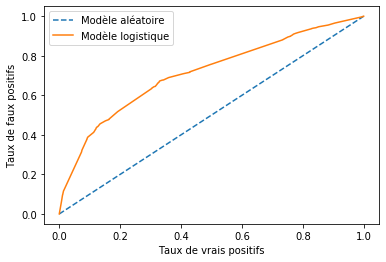

In [86]:
courbe_roc(classification, classification.predict_proba(xTest)[:, 1], yTest)

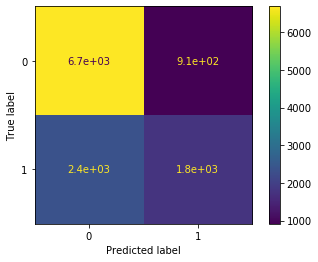

In [81]:
matrice_confusion(classification)

### Régression logistique

In [70]:
import statsmodels as sm
from statsmodels.tools import add_constant
XTrainBis = sm.tools.add_constant(xTrain)

from statsmodels.api import Logit
#régression logistique - on passe la cible et les explicatives
modele_logistique = Logit(endog=yTrain,exog=XTrainBis).fit()

Optimization terminated successfully.
         Current function value: 0.569682
         Iterations 6


In [46]:
print(modele_logistique.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                51772
Model:                          Logit   Df Residuals:                    51760
Method:                           MLE   Df Model:                           11
Date:                Thu, 30 Dec 2021   Pseudo R-squ.:                  0.1311
Time:                        21:00:41   Log-Likelihood:                -29494.
converged:                       True   LL-Null:                       -33942.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -2.2296      0.036    -61.748      0.000      -2.300      -2.159
Route dep ou nationale       0.7356      0.021     34.657      0.000       0.694       0.

On remarque que les variables "A chaussées séparées" (circ) et "Plein jour" (lum) ne sont pas significatives au seuil de 5%. On regroupe donc la modalité plein jour avec la modalité "Nuit avec éclairage public allumé" et la modalité "Chaussées Séparées" avec "A sens unique".

In [68]:
# Les variables explicatives sous forme d'indicatrices
col2 = ["Route dep ou nationale", "Sur accotement", "Autre lieu de l'accident", "Hors agglomeration",
       "Bidirectionnelle", "Nuit sans éclairage",
       "Sans collision", "Autre collision", "Courbe"]

# Créer de la base de donner avec uniquement les variables explicatives
df_temp2 = df_accidents[col2]

# Création des échantillons de test et d'apprentissage
xTrain2, xTest2, yTrain2, yTest2 = train_test_split(df_temp2, df_accidents["y"].values.ravel(), test_size = 0.2, random_state = 0)

In [69]:
modele_logistique_2 = Logit(endog=yTrain2,exog=sm.tools.add_constant(xTrain2)).fit()

Optimization terminated successfully.
         Current function value: 0.569691
         Iterations 5


/Users/cloclo/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [72]:
print(modele_logistique_2.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                51772
Model:                          Logit   Df Residuals:                    51762
Method:                           MLE   Df Model:                            9
Date:                Fri, 31 Dec 2021   Pseudo R-squ.:                  0.1310
Time:                        14:20:49   Log-Likelihood:                -29494.
converged:                       True   LL-Null:                       -33942.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -2.2041      0.024    -91.101      0.000      -2.252      -2.157
Route dep ou nationale       0.7352      0.021     34.680      0.000       0.694       0.

#### Interprétation des coefficients :

Pour interprêter les coefficients, on utilise les odd ratios. Il y a plus de risque que l'accident soit grave s'il a lieu sur une route département ou nationale, hors agglomération, sur une route bidirectionnelle, sans éclarage.

In [79]:
model_odds = pd.DataFrame(modele_logistique_2.params, columns= ['Coefficient'])
model_odds["Odd Ratio"] = np.exp(modele_logistique_2.params)
model_odds['p-value']= modele_logistique_2.pvalues
model_odds[['2.5%', '97.5%']] = np.exp(modele_logistique_2.conf_int())

model_odds

,Coefficient,Odd Ratio,p-value,2.5%,97.5%
const,-2.204127,0.110347,0.000000e+00,0.105236,0.115706
Route dep ou nationale,0.735244,2.085991,1.592760e-263,2.001088,2.174497
Sur accotement,0.624996,1.868238,3.823150e-47,1.716095,2.033868
Autre lieu de l'accident,0.501348,1.650946,3.319527e-35,1.524981,1.787316
Hors agglomeration,0.881570,2.414687,0.000000e+00,2.307246,2.527132
Bidirectionnelle,0.880892,2.413050,0.000000e+00,2.310026,2.520669
Nuit sans éclairage,0.263875,1.301965,8.328482e-16,1.220942,1.388366
Sans collision,0.407389,1.502889,1.101387e-29,1.400493,1.612772
Autre collision,0.513477,1.671091,3.206670e-107,1.596352,1.749328
Courbe,0.273519,1.314582,2.699425e-26,1.249806,1.382715


#### Evaluation de la performance du modele :

Modèle aléatoire : ROC AUC=0.500
Modèle logistique : ROC AUC=0.731


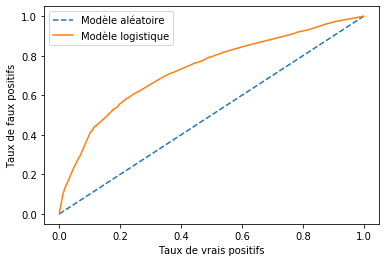

Modèle aléatoire : ROC AUC=0.500
Modèle logistique : ROC AUC=0.733


/Users/cloclo/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:130: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


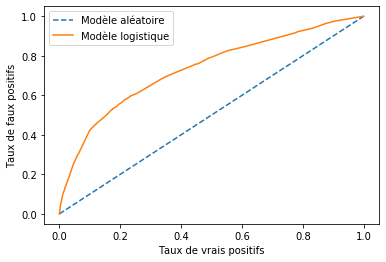

In [109]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from bioinfokit.visuz import stat

pred = modele_logistique_2.predict(sm.tools.add_constant(xTest2))
courbe_roc(modele_logistique_2, pred, xTest2, yTest2)

pred_train = modele_logistique_2.predict(sm.tools.add_constant(xTrain2))
courbe_roc(modele_logistique_2, pred_train, xTrain2, yTrain2)

### Arbre de décision